# Grid-Characteristic Courant-Isaacson-Rees method

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import clear_output, HTML
from tqdm import tqdm_notebook

In [2]:
# Plotting functions

def plot(u):
    """ u(x, t) for fixed t """
    global x
    plt.figure()#figsize=(10, 6)
    plt.xlabel('$x$')
    plt.ylabel('$u(x)$')
    plt.plot(x, u)

def plot_all(u):
    plt.figure(figsize=(6, 6))
    plt.imshow(u)
    plt.xlabel('$x$')
    plt.ylabel('$t$')
    cbar = plt.colorbar()
    cbar.set_label('$u(x, t)$')

def animate(data):
    global x
    y = data
    line.set_data(x,y)
    return line,

Initial condition:

$u(x, 0) = \phi(x) \ge \varepsilon > 0$

Boundary conditions:

$u(x_0, t) = \phi(x_0)$

$u(x_1, t) = \phi(x_1)$

In [3]:
x0, x1 = -5, 5
Nx = 101
x = np.linspace(x0, x1, Nx, dtype=np.float64)

In [4]:
Nt = 101
t = np.zeros(Nt, dtype=np.float64)

In [5]:
eps = 1
def phi0(x):
    return np.where(np.abs(x + 2) > 2, 0, 2-np.abs(x + 2)) + eps
def phi1(x):
    return np.exp(-(x + 2)**2) + eps
def phi2(x):
    return 1 / np.cosh(x + 2) ** 2 + eps

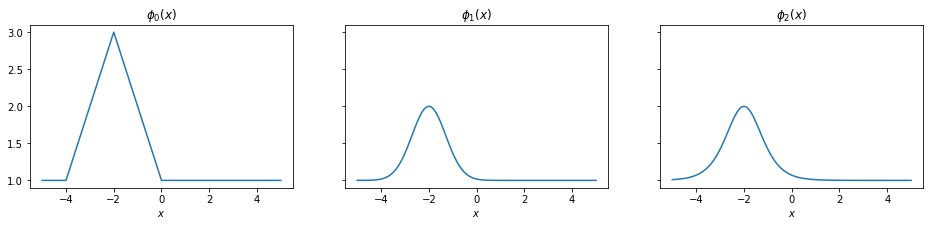

In [6]:
fig, axs = plt.subplots(ncols=3, figsize=(16, 3), sharey=True)
for i, phi in enumerate([phi0, phi1, phi2]):
    axs[i].plot(x, phi(x))
    axs[i].set_title(f'$\phi_{i}(x)$')
    axs[i].set_xlabel('$x$')

In [7]:
u = np.ones((Nt, Nx), dtype=np.float64) * eps
u[0] = phi0(x)

$v = u^2,~t=t_0$ 

In [8]:
v = np.zeros((Nt, Nx), dtype=np.float64)
v[0] = u[0] ** 2

$
R^{+} = \dfrac{1}{3} \left(u - \sqrt{u^{2} + 3 v}\right) u - \dfrac{v}{2},~t = t_0
$

In [9]:
Rp = np.zeros((Nt, Nx), dtype=np.float64)
Rp[0] = (u[0] - np.sqrt(u[0] ** 2 + 3 * v[0])) * u[0] / 3 - 0.5 * v[0]

$
R^{-} = \dfrac{1}{3} \left(u + \sqrt{u^{2} + 3 v}\right) u - \dfrac{v}{2},~t = t_0
$

In [10]:
Rm = np.zeros((Nt, Nx), dtype=np.float64)
Rm[0] = (u[0] + np.sqrt(u[0] ** 2 + 3 * v[0])) * u[0] / 3 - 0.5 * v[0]

$\dfrac{R_m^{+n+1}-R_m^{+n}}{\tau} + \dfrac{1}{3}\left(u + \sqrt{u^2 + 3v}\right)_m^n\dfrac{R_m^{+n}-R_{m-1}^{+n}}{h}=0$

$\dfrac{R_m^{-n+1}-R_m^{-n}}{\tau} + \dfrac{1}{3}\left(u - \sqrt{u^2 + 3v}\right)_m^n\dfrac{R_{m+1}^{-n}-R_m^{-n}}{h}=0$

$R_m^{+n+1} = R_m^{+n} - \dfrac{\tau}{3h}\left(u + \sqrt{u^2 + 3v}\right)_m^n\left(R_m^{+n}-R_{m-1}^{+n}\right)$

$R_m^{-n+1} = R_m^{-n} - \dfrac{\tau}{3h}\left(u - \sqrt{u^2 + 3v}\right)_m^n\left(R_{m+1}^{-n}-R_m^{-n}\right)$

$u = -\dfrac{3}{2} \dfrac{R^{+} - R^{-}}{\sqrt{u^{2} + 3 v}}$

$v = -\dfrac{(u + \sqrt{u^{2} + 3 v}) R^+ - (u - \sqrt{u^{2} + 3 v}) R^-}{\sqrt{u^{2} + 3 v}}$

In [11]:
h = (x1 - x0) / (Nx - 1)
Cu = 0.9

In [12]:
for n in tqdm_notebook(range(Nt - 1)):
    tau = Cu * h / np.max(u[n])
    
    A = tau / (3 * h)
    B = np.sqrt(u[n] ** 2 + 3 * v[n])
    
    Rp[n + 1, 1:-1] = Rp[n, 1:-1] - A * (u[n, 1:-1] + B[1:-1]) * (Rp[n, 1:-1] - Rp[n, :-2])
    Rm[n + 1, 1:-1] = Rm[n, 1:-1] - A * (u[n, 1:-1] - B[1:-1]) * (Rm[n, 2:] - Rm[n, 1:-1])
    
    u[n + 1] = - 1.5 * (Rp[n + 1] - Rm[n + 1]) / B
    v[n + 1] = - ((u[n] + B) * Rp[n + 1] - (u[n] - B) * Rm[n + 1]) / B
    
    # BC
    u[n + 1, [0, -1]] = u[n, [0, -1]]
    v[n + 1, [0, -1]] = v[n, [0, -1]]
    Rp[n + 1, [0, -1]] = Rp[n, [0, -1]]
    Rm[n + 1, [0, -1]] = Rm[n, [0, -1]]
    
    t[n + 1] = t[n] + tau

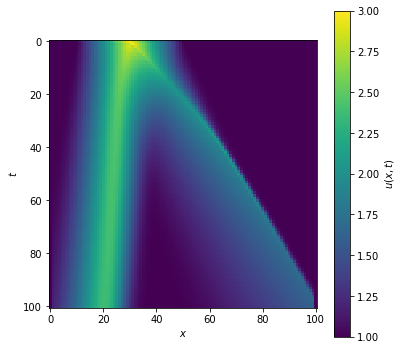

In [13]:
plot_all(u)

In [14]:
fig = plt.figure();#figsize=(10, 6)
ax = plt.axes(xlim=(-5,5),ylim=(0,5), xlabel=('$x$'),ylabel=('$u(x)$'));
line, = plt.plot([],[]); # ,color='#003366', lw=2

anim = animation.FuncAnimation(fig, animate, frames=u, interval=100);

#anim.save('gifs/GC_CIR_v0.gif', writer='pillow')
anim.save('GC_CIR_v0.mp4', writer="ffmpeg")

In [15]:
HTML(anim.to_jshtml())

In [16]:
HTML(anim.to_html5_video())